In [1]:
import numpy as np
import matplotlib.pyplot as plt
import dill
import sympy
from tqdm import tqdm
import gmsh

### Load precomputed integrals

In [2]:
lagrange_linear_poisson_matrix = dill.load(
    open("../calculations/lagrange_linear_poisson_matrix", "rb")
)
lagrange_linear_poisson_right_values = dill.load(
    open("../calculations/lagrange_linear_poisson_right_values", "rb")
)
lagrange_linear_poisson_right_values_neuman = dill.load(
    open("../calculations/lagrange_linear_poisson_right_values_neuman", "rb")
)

### Run triangulation

In [3]:
gmsh.initialize()
gmsh.model.add("tri_mesh")

point_mesh_size = 0.1
point_2 = gmsh.model.geo.addPoint(+1, +1, 0, point_mesh_size)
point_3 = gmsh.model.geo.addPoint(-1, +1, 0, point_mesh_size)
point_4 = gmsh.model.geo.addPoint(-1, -1, 0, point_mesh_size)
point_5 = gmsh.model.geo.addPoint(+1, -1, 0, point_mesh_size)

arc_1 = gmsh.model.geo.addLine(point_2, point_3)
arc_2 = gmsh.model.geo.addLine(point_3, point_4)
arc_3 = gmsh.model.geo.addLine(point_4, point_5)
arc_4 = gmsh.model.geo.addLine(point_5, point_2)

circle = gmsh.model.geo.addCurveLoop([arc_1, arc_2, arc_3, arc_4])

plane = gmsh.model.geo.addPlaneSurface([circle])

gmsh.model.geo.synchronize()

gmsh.model.mesh.setTransfiniteCurve(arc_1, 13)
gmsh.model.mesh.setTransfiniteCurve(arc_2, 13)
gmsh.model.mesh.setTransfiniteCurve(arc_3, 13)
gmsh.model.mesh.setTransfiniteCurve(arc_4, 13)
gmsh.model.mesh.setTransfiniteSurface(plane)

physical_group_curves_tag = gmsh.model.addPhysicalGroup(1, [arc_1, arc_2, arc_3, arc_4], name="Boundary curves")
physical_group_surface_tag = gmsh.model.addPhysicalGroup(2, [plane], name="Surface")


gmsh.model.mesh.generate(2)
gmsh.fltk.run()

In [4]:
boundary_node_tags, boundary_node_coords = gmsh.model.mesh.getNodesForPhysicalGroup(1, physical_group_curves_tag)
surface_node_tags, points = gmsh.model.mesh.getNodesForPhysicalGroup(2, physical_group_surface_tag)
points = points.reshape(-1, 3)[:, :-1]
boundary_node_tags = boundary_node_tags - 1

In [5]:
element_types, element_tags, element_node_tags = gmsh.model.mesh.getElements()
triangles = [nodes for elem_type, nodes in zip(element_types, element_node_tags) if elem_type == 2][0]
triangles = triangles.reshape(-1, 3).astype(int)
triangles = triangles - 1

In [6]:
edges = [nodes for elem_type, nodes in zip(element_types, element_node_tags) if elem_type == 1][0]
edges = edges.reshape(-1, 2).astype(int)
edges = edges - 1

In [7]:
vertex_marker_is_boundary = np.zeros(surface_node_tags.shape[0])
vertex_marker_is_boundary[boundary_node_tags] = 1

In [8]:
def orient_batch(arg):
    indices = np.argsort(arg, axis=-1)
    vertices = np.take_along_axis(arg, indices, axis=-1)

    return vertices

In [9]:
triangles = orient_batch(triangles)

In [10]:
x, y = sympy.symbols("x y")

In [26]:
F = sympy.Float(1)
Fn = sympy.Float(0)*x
right_vals = np.zeros((points.shape[0]))
right_vals[:] = sympy.lambdify((x, y), F)(*points.T)
right_vals_n = np.zeros((points.shape[0]))
right_vals_n[:] = sympy.lambdify((x, y), Fn)(*points.T)

In [38]:
matrix = np.zeros((points.shape[0], points.shape[0]))
b = np.zeros(points.shape[0])

for idx, element in enumerate(tqdm(triangles)):
    x1, x2, x3 = points[element[0], 0], points[element[1], 0], points[element[2], 0]
    y1, y2, y3 = points[element[0], 1], points[element[1], 1], points[element[2], 1]

    FF = lagrange_linear_poisson_matrix(x1, y1, x2, y2, x3, y3)
    ff = lagrange_linear_poisson_right_values(x1, y1, x2, y2, x3, y3, right_vals[element[0]], right_vals[element[1]], right_vals[element[2]])

    for local_point in range(3):
        if vertex_marker_is_boundary[element[local_point]] == True:
            
            if False and (np.isclose(points[element[local_point]][1], 1) or np.isclose(points[element[local_point]][1], -1)):
                   
                num_boundary_vertices = vertex_marker_is_boundary[element].sum()
                
                if num_boundary_vertices >= 2:
                    
                    if num_boundary_vertices == 3:
                        eidx = np.where(abs(points[element][:, 1]) < 1)[0]
                    else:
                        eidx = np.where(vertex_marker_is_boundary[element] == 0)[0]                                         
                    
                    ffn = lagrange_linear_poisson_right_values_neuman(
                                                                        x1, y1, 
                                                                        x2, y2, 
                                                                        x3, y3, 
                                                                        right_vals_n[element[0]], 
                                                                        right_vals_n[element[1]], 
                                                                        right_vals_n[element[2]],
                                                                        int(eidx)
                                                                    )
                    
                    for i in range(3):
                        matrix[element[local_point], element[i]] += FF[local_point, i]
                        
                    b[element[local_point]] += +ffn[local_point, 0] - ff[local_point, 0]
                                                            
            else:
                matrix[element[local_point], element[local_point]] = 1
                b[element[local_point]] *= 0
        else:
            for i in range(3):
                matrix[element[local_point], element[i]] += FF[local_point, i]

            b[element[local_point]] -= ff[local_point, 0]

100%|██████████| 288/288 [00:00<00:00, 146703.86it/s]


In [39]:
_x_ = points[:, 0]
_y_ = points[:, 1]

In [40]:
F = np.linalg.solve(matrix, b)

In [41]:
eigenvalues, eigenvectors = np.linalg.eigh(matrix)

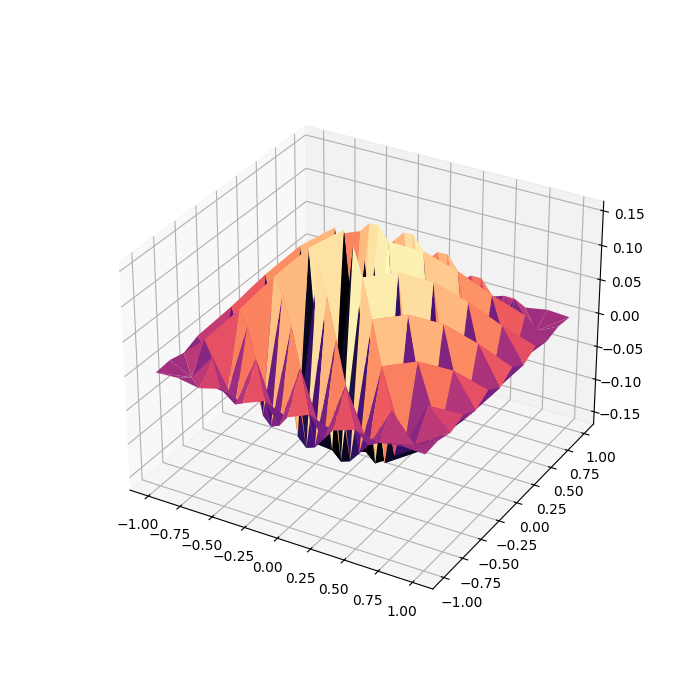

In [47]:
%matplotlib widget
fig = plt.figure(figsize=(7, 7))
ax = plt.axes(projection="3d")
ax.plot_trisurf(_x_, _y_, eigenvectors[:, -1], cmap="magma")
plt.show()